In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import csv
import tqdm
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from PIL import Image
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

In [3]:
%run 'yolov3_tf2.ipynb'

In [4]:
%run 'utils.ipynb'

In [5]:
model_size = (416, 416, 3) #1080 1920 416
max_output_size = 40
max_output_size_per_class = 20
iou_threshold = 0.5
confidence_threshold = 0.5

num_classes = 80
class_name = './data/classes_80.txt'
cfgfile = 'cfg/yolov3_80.cfg'
weightfile = 'weights/yolov3_80_weights.tf'

In [6]:
model = YOLOv3Net(cfgfile,model_size,num_classes)
model.load_weights(weightfile)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 416, 416, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
______________________________________________________________________________________________

In [8]:
from lyft_dataset_sdk.lyftdataset import LyftDataset
cur_dir = os.path.dirname(os.getcwd())
sample = pd.read_json(cur_dir + '/train_data/sample_data.json')
sample = sample[['filename','sample_token','token','timestamp']][sample.fileformat == 'jpeg'].drop_duplicates()
sample['timestamp'] = pd.to_datetime(sample['timestamp'])

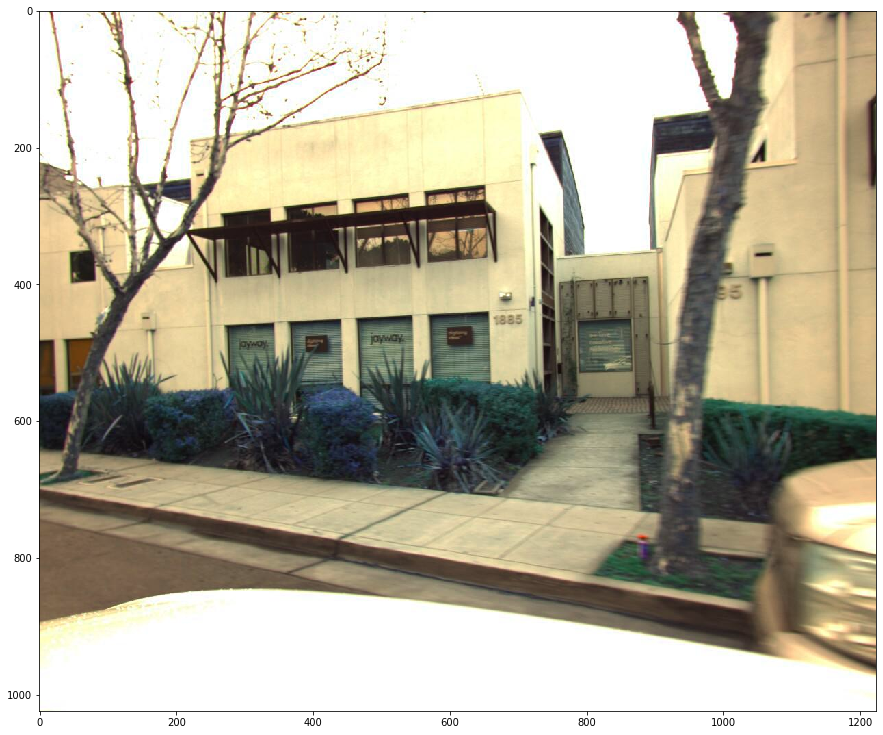

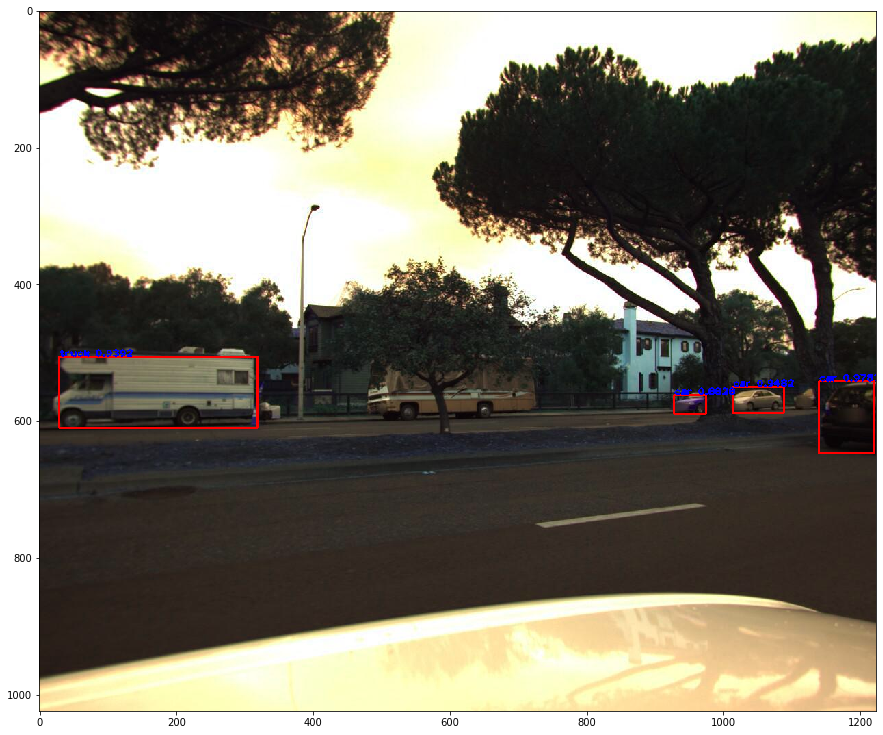

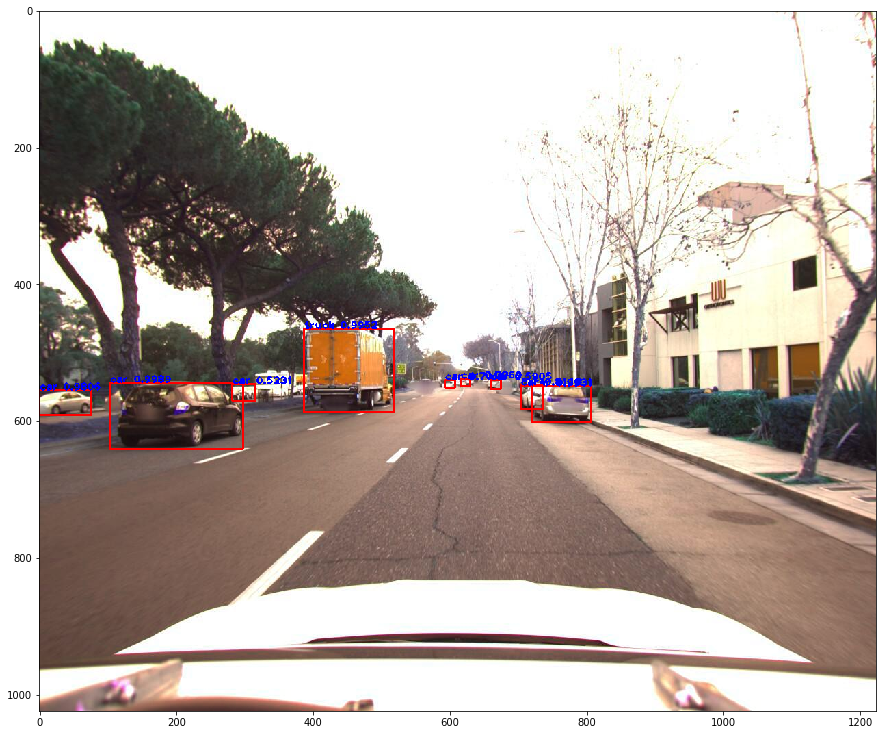

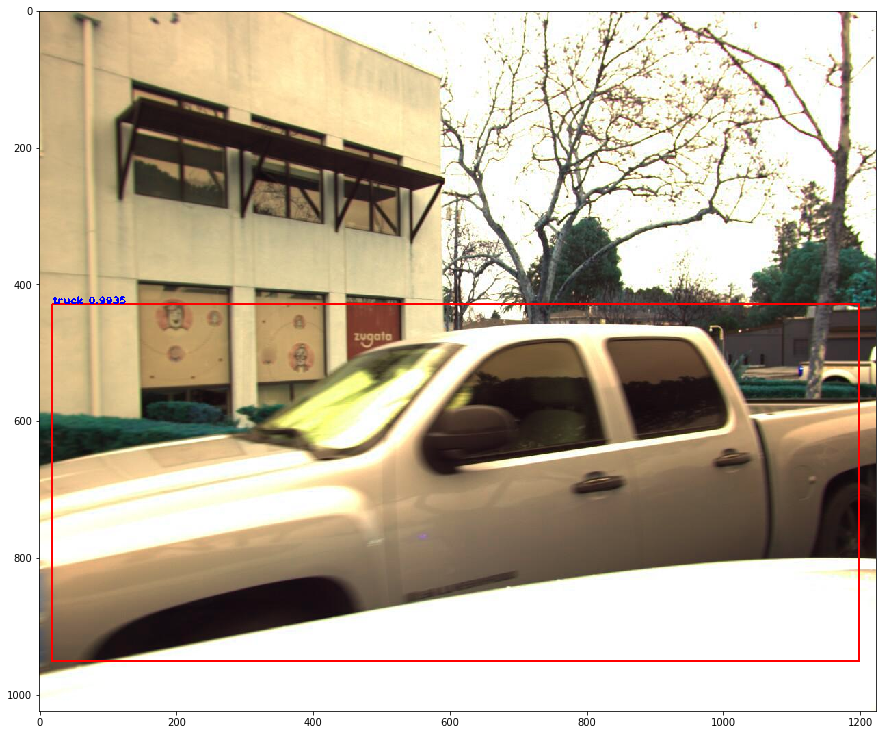

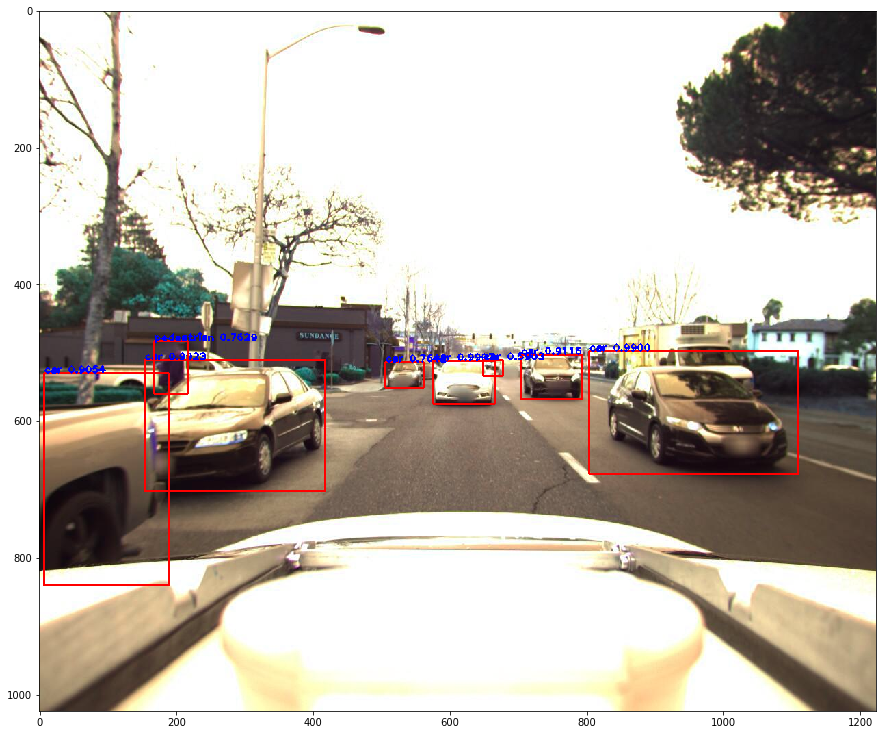

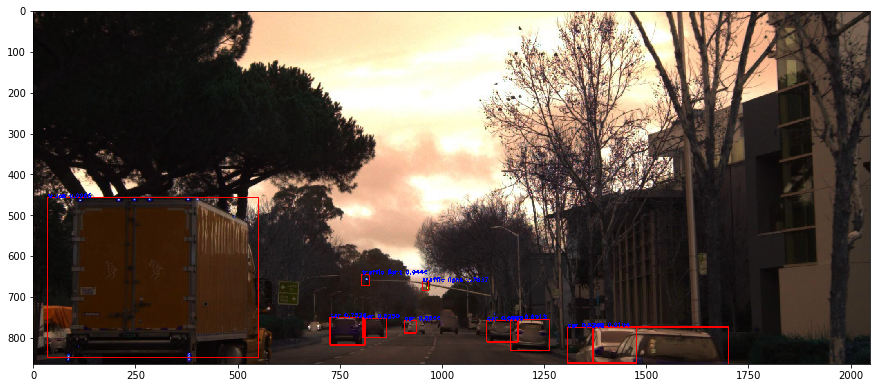

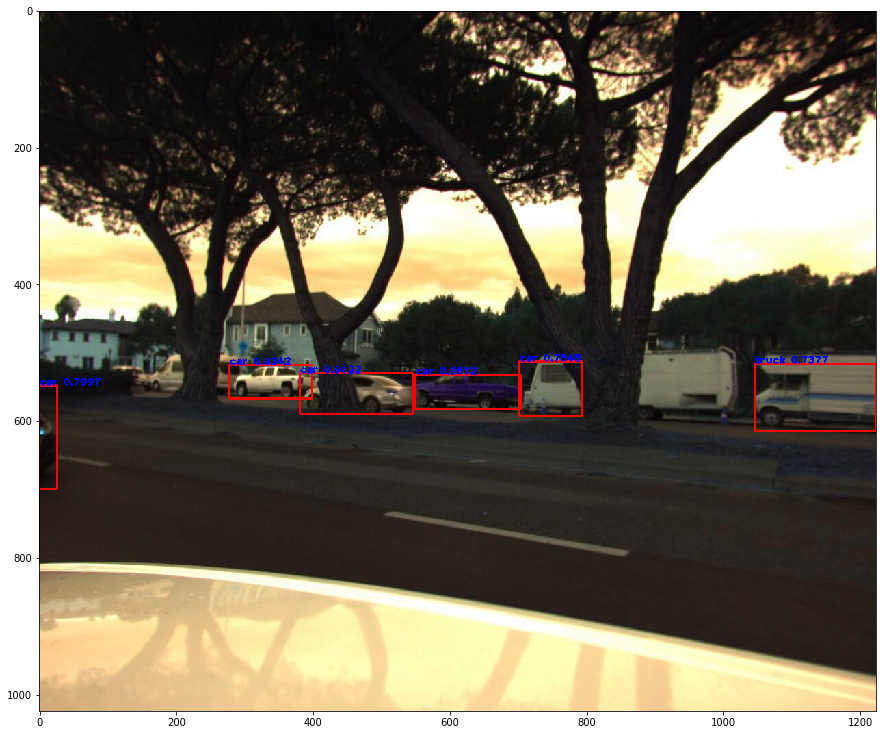

In [9]:
class_names = load_class_names(class_name) 
for i,row in sample[sample.sample_token.str.contains('5c72da8e708cc22fd95847985f403547')].iterrows(): 
    img_path = cur_dir+'/'+row.filename
   
    image = cv2.imread(img_path)
    #image = plt.imread(img_path)
    image = np.array(image)
    image = tf.expand_dims(image, 0)

    resized_frame = resize_image(image, (model_size[0],model_size[1]))
    pred = model.predict(resized_frame)
    
    boxes, scores, classes, nums = output_boxes(
    pred, model_size,
    max_output_size=max_output_size,
    max_output_size_per_class=max_output_size_per_class,
    iou_threshold=iou_threshold,
    confidence_threshold=confidence_threshold)
    image = np.squeeze(image)
    img = draw_outputs(image, boxes, scores, classes, nums, class_names)
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,15))
    plt.imshow(img)
#plt.savefig('final_img/test.png')

In [10]:
def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
                 weights_path='model_data/yolov3.h5'):
    '''create the training model'''
    # tf.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [
        Input(shape=(h // {0: 32, 1: 16, 2: 8}[l], w // {0: 32, 1: 16, 2: 8}[l], num_anchors // 3, num_classes + 5)) for
        l in range(3)]

    model_body = yolo_body(image_input, num_anchors // 3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers) - 3)[freeze_body - 1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
                        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

In [11]:
def train_model():
    annotation_path = 'data/test_annotation.txt'
    log_dir = 'logs/000/'
    classes_path = 'data/classes.txt'
    cfgfile = 'cfg/yolov3.cfg'
    anchors_path = 'data/yolo_anchors.txt'
    class_names = load_class_names(classes_path)
    print("-------------------CLASS NAMES-------------------")
    print(class_names)
    print("-------------------CLASS NAMES-------------------")
    num_classes = len(class_names)
    anchors = get_anchors(anchors_path)

    input_shape = (416, 416) # multiple of 32, hw
    model_size = (416, 416, 3) 
    
    #model = YOLOv3Net(cfgfile,model_size,num_classes)
    model = create_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='data/yolov3.h5') # make sure you know what you freeze

    logging = TensorBoard(log_dir=log_dir)
    checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

    val_split = 0.2
    with open(annotation_path) as f:
        lines = f.readlines()
    np.random.seed(10101)
    np.random.shuffle(lines)
    np.random.seed(None)
    num_val = int(len(lines)*val_split)
    num_train = len(lines) - num_val

    # Train with frozen layers first, to get a stable loss.
    # Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
    if True:
        model.compile(optimizer=Adam(lr=1e-3))#, loss={
            # use custom yolo_loss Lambda layer.
           # 'yolo_loss': lambda y_true, y_pred: y_pred})
        
        #model.compile(optimizer=Adam(lr=1e-3),  # Optimizer
                      # Loss function to minimize
                      #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      # List of metrics to monitor
                      #metrics=['accuracy'])

        batch_size = 32
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        
        model.fit(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                  steps_per_epoch=max(1, num_train // batch_size),
                  validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors,
                                                         num_classes),
                  validation_steps=max(1, num_val // batch_size),
                  epochs=500,
                  initial_epoch=0,
                  callbacks=[logging, checkpoint])
        model.save_weights(log_dir + 'trained_weights_stage_1.h5')

    # Unfreeze and continue training, to fine-tune.
    # Train longer if the result is not good.
    if False:
        for i in range(len(model.layers)):
            model.layers[i].trainable = True
        model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
        print('Unfreeze all of the layers.')

        batch_size = 32 # note that more GPU memory is required after unfreezing the body
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=100,
            initial_epoch=50,
            callbacks=[logging, checkpoint, reduce_lr, early_stopping])
        model.save_weights(log_dir + 'trained_weights_final.h5')

In [12]:
train_model()

-------------------CLASS NAMES-------------------
['truck', 'car', 'other_vehicle', 'pedestrian', 'bus', 'motorcycle', 'bicycle', 'emergency_vehicle', 'animal']
-------------------CLASS NAMES-------------------
Create YOLOv3 model with 9 anchors and 9 classes.
Load weights data/yolov3.h5.
Freeze the first 249 layers of total 252 layers.
Train on 10 samples, val on 2 samples, with batch size 32.
[[0.85516673 0.5129287  1.         0.72689223 2.        ]
 [0.8821707  0.4763735  0.90336853 0.4946714  2.        ]
 [0.79598236 0.48107308 0.8309115  0.5022404  2.        ]
 [0.84440297 0.4786369  0.8659899  0.49824825 2.        ]]
[[0.44280523 0.25667354 0.4720756  0.42165136 9.        ]
 [0.25772896 0.24339086 0.29336584 0.4073876  9.        ]
 [0.03437803 0.26052526 0.06294796 0.42272362 9.        ]
 [0.4490937  0.9158745  0.49165568 0.97981715 2.        ]
 [0.7991807  0.5961209  0.8306465  0.7256993  9.        ]
 [0.3719321  0.9304936  0.44304672 0.9996898  2.        ]
 [0.48971015 0.914578

[[4.8479850e-02 4.3568530e-01 9.9679524e-01 9.2151827e-01 2.0000000e+00]
 [8.9082350e-04 4.7851896e-01 1.7354369e-01 6.1035590e-01 2.0000000e+00]
 [2.1421781e-01 3.5394960e-01 2.3090197e-01 3.9437660e-01 9.0000000e+00]
 [7.6838070e-01 5.3831536e-01 9.8506750e-01 6.2532480e-01 2.0000000e+00]
 [6.5525943e-01 5.2589700e-01 7.8658800e-01 5.9737010e-01 2.0000000e+00]
 [5.7109963e-04 4.9019894e-01 2.1037675e-02 5.3617215e-01 2.0000000e+00]]
[[0.6809119  0.4978306  0.99796396 0.70268834 2.        ]
 [0.         0.46948734 0.45457825 0.79430413 2.        ]
 [0.7475549  0.12738393 0.77990764 0.21010344 9.        ]]
[[0.44280523 0.25667354 0.4720756  0.42165136 9.        ]
 [0.25772896 0.24339086 0.29336584 0.4073876  9.        ]
 [0.03437803 0.26052526 0.06294796 0.42272362 9.        ]
 [0.4490937  0.9158745  0.49165568 0.97981715 2.        ]
 [0.7991807  0.5961209  0.8306465  0.7256993  9.        ]
 [0.3719321  0.9304936  0.44304672 0.9996898  2.        ]
 [0.48971015 0.9145783  0.5555454  1. 

TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'